This notebook contains the modeling part for the full dataset. For the text cleaning portion, refer to 'yelp-3categories'.

In [1]:
import os
import codecs
import json
import spacy
import numpy as np
import pandas as pd
import itertools as it
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from textblob import TextBlob

No handlers could be found for logger "gensim.models.word2vec"


In [2]:
data_directory = os.path.join('dataset')
review_filepath = os.path.join(data_directory,'yelp_academic_dataset_review.json')
result_directory = os.path.join('result-3categories')
review_txt_filepath = os.path.join(result_directory,'review_text.txt')
star_txt_filepath = os.path.join(result_directory,'star_text.txt')

In [3]:
unigram_sentences_filepath = os.path.join(result_directory,'unigram_sentences_all.txt')

In [4]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [3]:
bigram_model_filepath = os.path.join(result_directory, 'bigram_model_all')

In [6]:
%%time

# bigram_model = Phrases(unigram_sentences)
# bigram_model.save(bigram_model_filepath)

bigram_model = Phrases.load(bigram_model_filepath)

CPU times: user 3.85 s, sys: 992 ms, total: 4.84 s
Wall time: 6.7 s


In [4]:
nlp = spacy.load('en')

In [8]:
def punct_space(token):
    return token.is_punct or token.is_space

def line_review(filename):
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    for parsed_review in nlp.pipe(line_review(filename), batch_size=10000, n_threads=4):        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [9]:
bigram_sentences_filepath = os.path.join(result_directory,'bigram_sentences_all.txt')

In [10]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [5]:
bigram_reviews_filepath = os.path.join(result_directory,'bigram_transformed_reviews_all.txt')

In [12]:
with codecs.open(bigram_reviews_filepath, 'w', encoding='utf_8') as f:

    for parsed_review in nlp.pipe(line_review(review_txt_filepath),
                                  batch_size=10000, n_threads=4):

        # lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in parsed_review
                          if not punct_space(token)]

        # apply the first-order and second-order phrase models
        bigram_review = bigram_model[unigram_review]

        # remove any remaining stopwords
        bigram_review = [term for term in bigram_review
                          if term not in spacy.en.STOPWORDS]

        # write the transformed review as a line in the new file
        bigram_review = u' '.join(bigram_review)
        f.write(bigram_review + '\n')

In [3]:
trigram_model_filepath = os.path.join(result_directory,'trigram_model_all')

In [4]:
trigram_sentences_filepath = os.path.join(result_directory,'trigram_sentences_all.txt')

In [5]:
trigram_reviews_filepath = os.path.join(result_directory,'trigram_transformed_reviews_all.txt')

In [6]:
# use bigram to create X
X_list=pd.read_table(bigram_reviews_filepath, skip_blank_lines=False ,names=['text'])
X=X_list.text

In [7]:
y_list=pd.read_table(star_txt_filepath,names=['stars'])
y=y_list.stars

In [8]:
print X.shape
print y.shape

(2225213,)
(2225213,)


In [16]:
# prints 10 reviews and their stars
for i in range(2225113,2225123):
    print X[i], y[i]

urban_renewal skin care bar place beauty need trust non_toxic eco_friendly product body amazing result owner taylor know ' care customer product definitely recommend place 3
urban_renewal professional helpful highly_recommend waxing skin service great 3
urban_renewal skin care bar best wo anywhere_else year use toxic face product skin hook mybody product face feel look good taylor owner helpful come listen need feel confident know product specific face extensive_knowledge product service reassuring definitely check place 3
urban_renewal skin care wow excellent customer service owner taylor incredibly helpful knowledgable know trust product nurture protect skin highly_recommend visit gem visit wo anywhere_else 3
town visit need facial waxing taylor amazing job skin feel amazing spa cute knowledgable definitely recommend try place 3
struggle perfect skincare range super sensitive age pale skin urban_renewal skin care bar hope search perfect product end meet taylor owner consultation clea

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [9]:
# countvectorizer on all 2.2 million reviews
vect = CountVectorizer()
X_dtm = vect.fit_transform(X.values.astype('U'))
# X_test_dtm = vect.transform(X_test.values.astype('U'))
# X_test_dtm2 = vect.transform(["ddgdhrrrgh00"])

In [10]:
X_dtm.shape

(2225213, 398101)

In [20]:
# cross validation naive-bayse
from sklearn.cross_validation import cross_val_score
nb = MultinomialNB()
scores = cross_val_score(nb,X_dtm, y, cv=5)
print scores                                              
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(nb,X_dtm, y, cv=5, scoring='f1_micro')
print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.75387322  0.73641423  0.74098907  0.77142607  0.79396776]
Accuracy: 0.76 (+/- 0.04)
f1: 0.76 (+/- 0.04)


In [21]:
# jobline pickle files to save vectorizer and nb pipeline
vect_nb_pipeline = Pipeline([('vect', vect), ('nb', nb)])
joblib.dump(vect_nb_pipeline, 'vect_nb_pipeline.pkl')

['vect_nb_pipeline.pkl']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train.values.astype('U'))
X_test_dtm = vect.transform(X_test.values.astype('U'))

In [27]:
nb = MultinomialNB()
nb.fit(X_dtm, y_train)
y_pred_nb = nb.predict(X_test_dtm)

print metrics.accuracy_score(y_test, y_pred_nb)
#print y_pred_class

0.771766875665


In [28]:
# classification report for all reviews and stars
print metrics.classification_report(y_test, y_pred_nb)
print metrics.confusion_matrix(y_test, y_pred_nb)

             precision    recall  f1-score   support

          1       0.70      0.68      0.69    112635
          2       0.37      0.48      0.42     70529
          3       0.90      0.86      0.88    373140

avg / total       0.79      0.77      0.78    556304

[[ 76309  25720  10606]
 [ 11584  33945  25000]
 [ 21039  33018 319083]]


In [29]:
# baseline
y_list.stars.value_counts()/len(y)

3    0.670748
1    0.202471
2    0.126781
Name: stars, dtype: float64

In [30]:
# pipeline and joblib on train data (just in case)
vect_nb_pipeline = Pipeline([('vect', vect), ('nb', nb)])

In [31]:
joblib.dump(vect_nb_pipeline, 'vect_nb_pipeline_ttt.pkl')

['vect_nb_pipeline_ttt.pkl',
 'vect_nb_pipeline_ttt.pkl_01.npy',
 'vect_nb_pipeline_ttt.pkl_02.npy',
 'vect_nb_pipeline_ttt.pkl_03.npy',
 'vect_nb_pipeline_ttt.pkl_04.npy',
 'vect_nb_pipeline_ttt.pkl_05.npy']

In [25]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, stratify=y, random_state=1)

In [28]:
vect2 = CountVectorizer()
X_train_dtm2 = vect2.fit_transform(X_train2.values.astype('U'))
X_test_dtm2 = vect2.transform(X_test2.values.astype('U'))
# X_test_dtm2 = vect.transform(["ddgdhrrrgh00"])

In [29]:
nb2 = MultinomialNB()
nb2.fit(X_train_dtm2, y_train2)
y_pred_nb2 = nb2.predict(X_test_dtm2)

print metrics.accuracy_score(y_test2, y_pred_nb2)
#print y_pred_class

0.774364376312


In [31]:
print metrics.classification_report(y_test, y_pred_nb)
print metrics.confusion_matrix(y_test, y_pred_nb)

             precision    recall  f1-score   support

          1       0.71      0.68      0.69    112540
          2       0.37      0.49      0.42     70773
          3       0.90      0.86      0.88    372991

avg / total       0.79      0.78      0.78    556304

[[ 76737  25453  10350]
 [ 11568  34332  24873]
 [ 20318  32349 320324]]


Confusion matrix, without normalization
[[ 76309  25720  10606]
 [ 11584  33945  25000]
 [ 21039  33018 319083]]


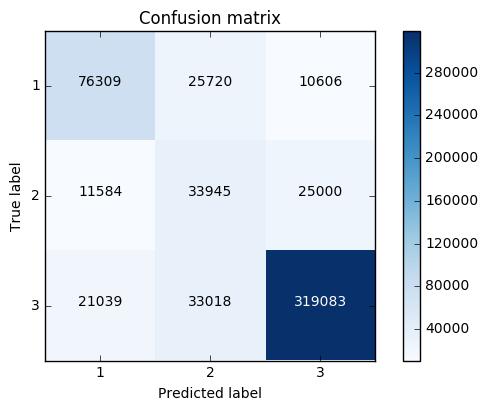

In [33]:
# better visualization for confusion matrix
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3],
                      title='Confusion matrix')

In [ ]:
rf=RandomForestClassifier()
rf.fit(X_train_dtm, y_train)
y_pred_rf = rf.predict(X_test_dtm)

print metrics.accuracy_score(y_test, y_pred_rf)

0.770729672985


In [34]:
# run Textblob sentiment on review texts
sentiment=[]
review_filepath = os.path.join(result_directory,'review_text.txt')
with codecs.open(review_filepath, 'r', encoding='utf_8') as review_file:
    for sentence in review_file:
        blob=TextBlob(sentence)
        sentiment.append(blob.sentiment.polarity)

In [35]:
print len(sentiment), X.shape

2225213 (2225213,)


In [36]:
# find the correlation between Textblob sentiment vs Yelp sentiment
np.corrcoef(sentiment,y)

array([[ 1.  ,  0.55],
       [ 0.55,  1.  ]])

In [53]:
sentiment_filepath = os.path.join(result_directory,'sentiment.txt')
with codecs.open(sentiment_filepath, 'w', encoding='utf_8') as f:

    for i in sentiment:
        f.write(str(i) + '\n')

In [14]:
sentiment_filepath = os.path.join(result_directory,'sentiment.txt')

In [21]:
sentiment=[]
sentiment_filepath = os.path.join(result_directory,'sentiment.txt')
with codecs.open(sentiment_filepath, 'r') as sentiment_file:
    for rating in sentiment_file:
        sentiment.append(float(rating))

In [23]:
sentiment2=np.asarray(sentiment)

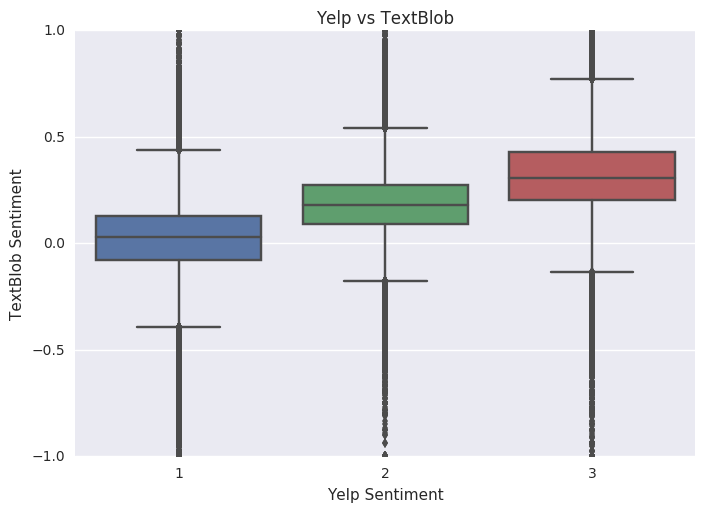

In [25]:
# boxplot for Yelp vs Textblob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
plt.style.context('fivethirtyeight')
ax = sns.boxplot(x=y_list.stars, y=sentiment2)
ax.set(xlabel='Yelp Sentiment', ylabel='TextBlob Sentiment', title='Yelp vs TextBlob')